In [1]:
import torch
from torch import optim
from torch import Tensor
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F 

from utils import *
import config
import random

from typing import Type

# from Classify import Classifier
# from Network_model import Generator, ConvModel
from ConvModel import ConvModel
from Generator import Generator
from GANSSL import GAN

from tqdm import tqdm

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :    DOODLE
NUM_LABELLED  :        50
DEVICE        :    cuda:0
EPOCHS        :        20
BATCH_SIZE    :        32
LEARNING_RATE :    0.0002
SCHED         :     False
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "GANSSL"

In [5]:
PATH = get_PATH(name)
PATH

'DOODLE/GANSSL/_50'

In [6]:

if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3

	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [8]:
X_full = train_ds.x
y_full = train_ds.y

In [9]:
classes

['0 - hat',
 '1 - bird',
 '2 - helicopter',
 '3 - book',
 '4 - windmill',
 '5 - car',
 '6 - octopus',
 '7 - cat',
 '8 - umbrella',
 '9 - birthday cake']

In [10]:
latent_size = 100
n_classes = len(classes)
channels = X_full.shape[1]
n_classes, channels

(10, 1)

In [11]:
# test dataloader
test_dl = CreateDataLoader(test_ds, batch_size=config.BATCH_SIZE, device=config.DEVICE)

In [12]:
X_sup, y_sup, X_unsup, _ = supervised_samples(X_full, y_full, config.NUM_LABELLED, n_classes, get_unsup=True) # type: ignore

In [13]:
class Discriminator(nn.Module):
	def __init__(self, in_channels, n_classes) -> None:
		super().__init__()

		self.conv = ConvModel(in_channels)

		self.dropout = nn.Dropout(0.5)

		self.classifier = nn.Linear(512, n_classes)
		
	def forward(self, X: Tensor):
		out = self.conv(X)
		out = self.dropout(out)
		out = self.classifier(out)
		return out

In [14]:
generator = Generator(latent_size, channels)
discriminator = Discriminator(channels, n_classes)

In [15]:
GANSSL = GAN(generator, discriminator, latent_size, config.DEVICE)

In [16]:
GANSSL.load_gen_state_dict(f'DCGAN/{config.USED_DATA}/netG_epoch_009.pt')

In [17]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)
full_ds = CustomDataSet(X_full, y_full, train_tfm)

In [18]:
history = GANSSL.fit(20, 64, 100, 0.00001, sup_ds, full_ds, optim.RMSprop, sched = config.SCHED, PATH=PATH+".pt", save=True)

Epoch [0]:


  2%|▏         | 2/100 [00:01<00:41,  2.38it/s]

  6%|▌         | 6/100 [00:01<00:14,  6.52it/s]

  8%|▊         | 8/100 [00:01<00:11,  7.88it/s]

 12%|█▏        | 12/100 [00:01<00:09,  9.62it/s]

 14%|█▍        | 14/100 [00:02<00:08, 10.14it/s]

 18%|█▊        | 18/100 [00:02<00:07, 10.75it/s]

 20%|██        | 20/100 [00:02<00:07, 10.91it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.17it/s]

 26%|██▌       | 26/100 [00:03<00:06, 11.25it/s]

 30%|███       | 30/100 [00:03<00:06, 11.34it/s]

 32%|███▏      | 32/100 [00:03<00:05, 11.35it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.38it/s]

 38%|███▊      | 38/100 [00:04<00:05, 11.39it/s]

 42%|████▏     | 42/100 [00:04<00:05, 11.38it/s]

 44%|████▍     | 44/100 [00:04<00:04, 11.39it/s]

 48%|████▊     | 48/100 [00:05<00:04, 11.41it/s]

 50%|█████     | 50/100 [00:05<00:04, 11.41it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 11.30it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.32it/s]

 60%|██████    | 60/100 [00:06<00:03, 11.26it/s]

 62%|██████▏   | 62/100 [00:06<00:03, 11.30it/s]

 66%|██████▌   | 66/100 [00:06<00:02, 11.35it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.28it/s]

 72%|███████▏  | 72/100 [00:07<00:02, 11.32it/s]

 74%|███████▍  | 74/100 [00:07<00:02, 11.33it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.37it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.37it/s]

 84%|████████▍ | 84/100 [00:08<00:01, 11.34it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 11.35it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.38it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.37it/s]

 96%|█████████▌| 96/100 [00:09<00:00, 11.35it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 11.37it/s]

100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


C_Loss: 0.08863, D_Loss: 0.14426
Epoch [1]:


  2%|▏         | 2/100 [00:00<00:08, 11.38it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.38it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.28it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.33it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.33it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.33it/s]

 10%|█         | 10/100 [00:00<00:07, 11.35it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.33it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.30it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.30it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.31it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.30it/s]

 20%|██        | 20/100 [00:01<00:07, 11.29it/s]

 20%|██        | 20/100 [00:01<00:07, 11.29it/s]

 22%|██▏       | 22/100 [00:02<00:06, 11.29it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.26it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.26it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.26it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.25it/s]

 30%|███       | 30/100 [00:02<00:06, 11.24it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.26it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.26it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.27it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.26it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.24it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.24it/s]

 40%|████      | 40/100 [00:03<00:05, 11.23it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.23it/s]

 44%|████▍     | 44/100 [00:03<00:04, 11.24it/s]

 44%|████▍     | 44/100 [00:03<00:04, 11.24it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.23it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.24it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.22it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.22it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.22it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.23it/s]

 56%|█████▌    | 56/100 [00:04<00:03, 11.23it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.23it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.17it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.18it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.19it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.19it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.20it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.22it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.21it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.21it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.23it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.26it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.24it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.24it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.26it/s]

 78%|███████▊  | 78/100 [00:06<00:01, 11.28it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.27it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.27it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.27it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.28it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.28it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.28it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.25it/s]

 90%|█████████ | 90/100 [00:07<00:00, 11.24it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.23it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.23it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.25it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.26it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.26it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.26it/s]

100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


C_Loss: 0.02850, D_Loss: 0.03283
Epoch [2]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.31it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.33it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.33it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.28it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.28it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.26it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.26it/s]

 10%|█         | 10/100 [00:00<00:07, 11.27it/s]

 10%|█         | 10/100 [00:00<00:07, 11.27it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.22it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.22it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.21it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.21it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.21it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.21it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.20it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.20it/s]

 20%|██        | 20/100 [00:01<00:07, 11.21it/s]

 20%|██        | 20/100 [00:01<00:07, 11.21it/s]

 22%|██▏       | 22/100 [00:01<00:06, 11.19it/s]

 22%|██▏       | 22/100 [00:02<00:06, 11.19it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.20it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.20it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.19it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.19it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.19it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.19it/s]

 30%|███       | 30/100 [00:02<00:06, 11.14it/s]

 30%|███       | 30/100 [00:02<00:06, 11.14it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.17it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.17it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.10it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.10it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.12it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.12it/s]

 40%|████      | 40/100 [00:03<00:05, 11.15it/s]

 40%|████      | 40/100 [00:03<00:05, 11.15it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.16it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.16it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.16it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.16it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.13it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.13it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.08it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.08it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.12it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.12it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.14it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.14it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.16it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.16it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.18it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.18it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.15it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.15it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.11it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.11it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.14it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.14it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.12it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.12it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.16it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.16it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.17it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.17it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.15it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.15it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.14it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.14it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.12it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.12it/s]

 78%|███████▊  | 78/100 [00:06<00:01, 11.11it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.11it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.13it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.13it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.13it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.13it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.11it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.11it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.10it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.10it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.14it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.14it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.08it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.08it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.10it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.10it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.12it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.12it/s]

100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


C_Loss: 0.01269, D_Loss: 0.00920
Epoch [3]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.19it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.19it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.11it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.11it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.10it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.10it/s]

 10%|█         | 10/100 [00:00<00:08, 11.07it/s]

 10%|█         | 10/100 [00:00<00:08, 11.07it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.00it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.00it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.03it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.03it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.04it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.04it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.05it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.05it/s]

 20%|██        | 20/100 [00:01<00:07, 11.06it/s]

 20%|██        | 20/100 [00:01<00:07, 11.06it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.02it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.02it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.03it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.03it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.04it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.04it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.05it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.05it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.99it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.99it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.99it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.99it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.01it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.01it/s]

 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.04it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.04it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.04it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.04it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.96it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.96it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.01it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.01it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.97it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.97it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.00it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.00it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.03it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.03it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.02it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.02it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.00it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.00it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.09it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.09it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.12it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.12it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.10it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.10it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.12it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.12it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.14it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.14it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.17it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.17it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.16it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.16it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.15it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.15it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.17it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.17it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.16it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.16it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.15it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.15it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.12it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.12it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.14it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.14it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.12it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 11.12it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.12it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.12it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.13it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.13it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.12it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.12it/s]

100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


C_Loss: 0.00764, D_Loss: 0.00232
Epoch [4]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.22it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.22it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.23it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.23it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.14it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.14it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.16it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.16it/s]

 10%|█         | 10/100 [00:00<00:08, 11.12it/s]

 10%|█         | 10/100 [00:00<00:08, 11.12it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.13it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.13it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.01it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.01it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.05it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.05it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.09it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.09it/s]

 20%|██        | 20/100 [00:01<00:07, 11.11it/s]

 20%|██        | 20/100 [00:01<00:07, 11.11it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.10it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.10it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.12it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.12it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.14it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.14it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.09it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.09it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.12it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.12it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.13it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.13it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.12it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.12it/s]

 40%|████      | 40/100 [00:03<00:05, 11.12it/s]

 40%|████      | 40/100 [00:03<00:05, 11.12it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.16it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.16it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.15it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.15it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.11it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.11it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.14it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.14it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.14it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.14it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.11it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.11it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.10it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.10it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.13it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.13it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.15it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.15it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.04it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.04it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.06it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.06it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.10it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.10it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.10it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.10it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.11it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.11it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.12it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.12it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.07it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.07it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.08it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.08it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.12it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.12it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.12it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.12it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.11it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.11it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.12it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.12it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.11it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.11it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.07it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.07it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.09it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 11.09it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.13it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.13it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.03it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.03it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.04it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.04it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.07it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.07it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.08it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.08it/s]

100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


C_Loss: 0.00414, D_Loss: 0.00109
Epoch [5]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.21it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.21it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.14it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.14it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.12it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.12it/s]

 10%|█         | 10/100 [00:00<00:08, 11.00it/s]

 10%|█         | 10/100 [00:00<00:08, 11.00it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.95it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.95it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.00it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.00it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.03it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.03it/s]

 20%|██        | 20/100 [00:01<00:07, 11.06it/s]

 20%|██        | 20/100 [00:01<00:07, 11.06it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.06it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.06it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.07it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.07it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.11it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.11it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.06it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.06it/s]

 30%|███       | 30/100 [00:02<00:06, 11.08it/s]

 30%|███       | 30/100 [00:02<00:06, 11.08it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.08it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.08it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.05it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.05it/s]

 40%|████      | 40/100 [00:03<00:05, 11.05it/s]

 40%|████      | 40/100 [00:03<00:05, 11.05it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.05it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.05it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.08it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.08it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.07it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.07it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.06it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.06it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.07it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.07it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.05it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.05it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.07it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.07it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.02it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.02it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.06it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.06it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.05it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.05it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.07it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.07it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.09it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.09it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.08it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.08it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.09it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.09it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.11it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.11it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.10it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.10it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.11it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.11it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.12it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.12it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.10it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.10it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.09it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.09it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.09it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.09it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.08it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 11.08it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.07it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.07it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.08it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.08it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.03it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.03it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.04it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.04it/s]

100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


C_Loss: 0.00209, D_Loss: 0.00040
Epoch [6]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.11it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.11it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.04it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.04it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.09it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.09it/s]

 10%|█         | 10/100 [00:00<00:08, 11.10it/s]

 10%|█         | 10/100 [00:00<00:08, 11.10it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.01it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.01it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.05it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.05it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.09it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.09it/s]

 20%|██        | 20/100 [00:01<00:07, 11.05it/s]

 20%|██        | 20/100 [00:01<00:07, 11.05it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.04it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.04it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.08it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.08it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.06it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.06it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.02it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.02it/s]

 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.06it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.06it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.09it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.09it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.06it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.06it/s]

 40%|████      | 40/100 [00:03<00:05, 11.10it/s]

 40%|████      | 40/100 [00:03<00:05, 11.10it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.06it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.06it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.03it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.03it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.04it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.04it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.05it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.05it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.05it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.05it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.08it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.08it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.06it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.06it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.09it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.09it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.03it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.03it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.02it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.02it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.02it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.02it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.00it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.00it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.99it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.99it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.02it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.02it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.01it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.01it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.05it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.05it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 10.92it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 10.92it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.98it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.98it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.00it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.00it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.99it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.99it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.87it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.87it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.90it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.90it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 10.98it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.98it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.97it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.97it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.97it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.97it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.98it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.98it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.93it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.93it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 10.96it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 10.96it/s]

100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


C_Loss: 0.00239, D_Loss: 0.00033
Epoch [7]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.02it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.02it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.05it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.05it/s]

 10%|█         | 10/100 [00:00<00:08, 11.08it/s]

 10%|█         | 10/100 [00:00<00:08, 11.08it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.99it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.99it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.01it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.01it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.02it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.02it/s]

 20%|██        | 20/100 [00:01<00:07, 11.04it/s]

 20%|██        | 20/100 [00:01<00:07, 11.04it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.02it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.02it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.00it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.00it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.01it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.01it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.00it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.00it/s]

 30%|███       | 30/100 [00:02<00:06, 10.99it/s]

 30%|███       | 30/100 [00:02<00:06, 10.99it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.03it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.03it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.02it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.02it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.05it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.05it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.02it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.02it/s]

 40%|████      | 40/100 [00:03<00:05, 11.05it/s]

 40%|████      | 40/100 [00:03<00:05, 11.05it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.04it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.04it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.05it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.05it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.05it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.05it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.06it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.04it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.04it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.06it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.06it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.05it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.05it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.06it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.06it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.05it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.05it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.03it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.03it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.04it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.04it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.06it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.06it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.04it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.04it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.07it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.07it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.07it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.07it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.04it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.04it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.08it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.08it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.01it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.01it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.04it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.04it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.01it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 11.01it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.05it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.05it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.98it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.98it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.01it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.01it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.00it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.00it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.02it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.02it/s]

100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


C_Loss: 0.00361, D_Loss: 0.00007
Epoch [8]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.17it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.17it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.04it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.04it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.00it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.00it/s]

 10%|█         | 10/100 [00:00<00:08, 11.02it/s]

 10%|█         | 10/100 [00:00<00:08, 11.02it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.95it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.95it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.99it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.99it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.94it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.94it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.99it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.99it/s]

 20%|██        | 20/100 [00:01<00:07, 10.99it/s]

 20%|██        | 20/100 [00:01<00:07, 10.99it/s]

 22%|██▏       | 22/100 [00:01<00:07, 11.01it/s]

 22%|██▏       | 22/100 [00:02<00:07, 11.01it/s]

 24%|██▍       | 24/100 [00:02<00:06, 10.95it/s]

 24%|██▍       | 24/100 [00:02<00:06, 10.95it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.00it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.00it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.01it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.01it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 30%|███       | 30/100 [00:02<00:06, 11.04it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.01it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.01it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.05it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.05it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.03it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.03it/s]

 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.03it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.03it/s]

 44%|████▍     | 44/100 [00:03<00:05, 10.98it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.98it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.98it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.98it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.96it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.96it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.00it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.00it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.95it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.95it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 10.99it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.99it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.94it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.94it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.98it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.98it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.84it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.84it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.87it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.87it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.93it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.93it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.90it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.90it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.89it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.89it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.97it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.97it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.98it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.98it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 10.96it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.96it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.87it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.87it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.91it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.91it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.95it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.95it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.99it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.99it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.97it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.97it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.79it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.79it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.84it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.84it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.90it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.90it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.97it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.97it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 10.98it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.98it/s]

100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


C_Loss: 0.00592, D_Loss: 0.00004
Epoch [9]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.15it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.04it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.04it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.10it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.10it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.56it/s]

 10%|█         | 10/100 [00:00<00:08, 10.76it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.89it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.89it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.92it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.98it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.01it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.01it/s]

 20%|██        | 20/100 [00:01<00:07, 11.01it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.98it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.04it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.04it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.08it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

 32%|███▏      | 32/100 [00:03<00:06, 11.05it/s]

 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.11it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.11it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.10it/s]

 40%|████      | 40/100 [00:03<00:05, 11.10it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.11it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.11it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.04it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.05it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.04it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.04it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.08it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.05it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.03it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.03it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.03it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.03it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.05it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.05it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.00it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.05it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.04it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 11.04it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.06it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.01it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.02it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.02it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.04it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.05it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.99it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.03it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.04it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.04it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.05it/s]

 88%|████████▊ | 88/100 [00:07<00:01, 11.08it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.04it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.04it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.07it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.04it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.03it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.03it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.04it/s]

100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


C_Loss: 0.00164, D_Loss: 0.00001
Epoch [10]:


  2%|▏         | 2/100 [00:00<00:08, 11.19it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.19it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.07it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.07it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.07it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.07it/s]

 10%|█         | 10/100 [00:00<00:08, 11.06it/s]

 12%|█▏        | 12/100 [00:01<00:07, 11.05it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.05it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.05it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.02it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.06it/s]

 20%|██        | 20/100 [00:01<00:07, 11.03it/s]

 20%|██        | 20/100 [00:01<00:07, 11.03it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.93it/s]

 24%|██▍       | 24/100 [00:02<00:06, 10.99it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.98it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.98it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.00it/s]

 30%|███       | 30/100 [00:02<00:06, 10.96it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.97it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.97it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.98it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.99it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.02it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.02it/s]

 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.08it/s]

 44%|████▍     | 44/100 [00:03<00:05, 11.10it/s]

 44%|████▍     | 44/100 [00:04<00:05, 11.10it/s]

 46%|████▌     | 46/100 [00:04<00:04, 11.08it/s]

 48%|████▊     | 48/100 [00:04<00:04, 11.10it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.02it/s]

 50%|█████     | 50/100 [00:04<00:04, 11.02it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 11.04it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.07it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.05it/s]

 56%|█████▌    | 56/100 [00:05<00:03, 11.05it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 11.08it/s]

 60%|██████    | 60/100 [00:05<00:03, 11.09it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.11it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 11.11it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.12it/s]

 66%|██████▌   | 66/100 [00:05<00:03, 11.09it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.07it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 11.07it/s]

 70%|███████   | 70/100 [00:06<00:02, 11.09it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 11.09it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.04it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 11.04it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 11.06it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.01it/s]

 80%|████████  | 80/100 [00:07<00:01, 11.01it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.06it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 11.07it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.07it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 11.07it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 11.10it/s]

 90%|█████████ | 90/100 [00:08<00:00, 11.11it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.05it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 11.05it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 11.08it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 11.09it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.09it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 11.09it/s]

100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


C_Loss: 0.00111, D_Loss: 0.00000
Epoch [11]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.03it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.03it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.00it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.00it/s]

 10%|█         | 10/100 [00:00<00:08, 11.02it/s]

 10%|█         | 10/100 [00:00<00:08, 11.02it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.98it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.98it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.01it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.01it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.95it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.95it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.00it/s]

 18%|█▊        | 18/100 [00:01<00:07, 11.00it/s]

 20%|██        | 20/100 [00:01<00:07, 11.02it/s]

 20%|██        | 20/100 [00:01<00:07, 11.02it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.97it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.97it/s]

 24%|██▍       | 24/100 [00:02<00:06, 10.88it/s]

 24%|██▍       | 24/100 [00:02<00:06, 10.88it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.76it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.76it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.86it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.86it/s]

 30%|███       | 30/100 [00:02<00:06, 10.88it/s]

 30%|███       | 30/100 [00:02<00:06, 10.88it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.96it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.96it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.96it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.96it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.05it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.05it/s]

 40%|████      | 40/100 [00:03<00:05, 11.07it/s]

 40%|████      | 40/100 [00:03<00:05, 11.07it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.02it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.02it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.94it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.94it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.92it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.92it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.92it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.92it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.79it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.79it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 10.81it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.81it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.88it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.88it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.93it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.93it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.85it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.85it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.92it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.92it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.96it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.96it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.99it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.99it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.94it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.94it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.94it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.94it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.95it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.95it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.99it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.99it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 10.97it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.97it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.01it/s]

 78%|███████▊  | 78/100 [00:07<00:01, 11.01it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.95it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.95it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.00it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 11.00it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.98it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.98it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.84it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.84it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.90it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.90it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.93it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.93it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.89it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.89it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.90it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.90it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.93it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.93it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 10.69it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.69it/s]

100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


C_Loss: 0.00179, D_Loss: 0.00000
Epoch [12]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.91it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.91it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.02it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.02it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.02it/s]

  8%|▊         | 8/100 [00:00<00:08, 11.02it/s]

 10%|█         | 10/100 [00:00<00:08, 10.97it/s]

 10%|█         | 10/100 [00:01<00:08, 10.97it/s]

 12%|█▏        | 12/100 [00:01<00:08, 11.00it/s]

 12%|█▏        | 12/100 [00:01<00:08, 11.00it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.96it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.96it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.92it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.92it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.91it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.91it/s]

 20%|██        | 20/100 [00:01<00:07, 10.94it/s]

 20%|██        | 20/100 [00:01<00:07, 10.94it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.97it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.97it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.00it/s]

 24%|██▍       | 24/100 [00:02<00:06, 11.00it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.93it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.93it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.91it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.91it/s]

 30%|███       | 30/100 [00:02<00:06, 10.95it/s]

 30%|███       | 30/100 [00:02<00:06, 10.95it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.96it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.96it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.93it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.93it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.88it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.88it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.84it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.84it/s]

 40%|████      | 40/100 [00:03<00:05, 10.82it/s]

 40%|████      | 40/100 [00:03<00:05, 10.82it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.57it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.65it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.70it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.75it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.75it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.81it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.85it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 10.88it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.88it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.83it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.87it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.87it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.87it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.86it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.90it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.76it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.76it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.76it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.83it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.86it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.86it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.77it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.58it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.58it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.74it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.77it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.84it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.84it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.85it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.86it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.86it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.86it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.89it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.89it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.85it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.85it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.71it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.77it/s]

100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


C_Loss: 0.00281, D_Loss: 0.00000
Epoch [13]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.93it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.96it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.98it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.98it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.86it/s]

 10%|█         | 10/100 [00:00<00:08, 10.91it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.85it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.85it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.87it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.84it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.83it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.83it/s]

 20%|██        | 20/100 [00:01<00:07, 10.84it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.88it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.79it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.79it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.86it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.91it/s]

 30%|███       | 30/100 [00:02<00:06, 10.85it/s]

 30%|███       | 30/100 [00:02<00:06, 10.85it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.90it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.91it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.94it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.94it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.88it/s]

 40%|████      | 40/100 [00:03<00:05, 10.89it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.89it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.89it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.92it/s]

 46%|████▌     | 46/100 [00:04<00:04, 10.95it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.96it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.96it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.99it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.99it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 10.89it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.89it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.91it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.89it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.91it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.91it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.89it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.88it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.68it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.68it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.75it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.76it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.76it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.76it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.84it/s]

 76%|███████▌  | 76/100 [00:06<00:02, 10.85it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.88it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.89it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.92it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.92it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.96it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.98it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.98it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.98it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.89it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.92it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.86it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.86it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.89it/s]

100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


C_Loss: 0.00284, D_Loss: 0.00000
Epoch [14]:


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.88it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.78it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.82it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.82it/s]

 10%|█         | 10/100 [00:01<00:08, 10.88it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.89it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.77it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.77it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.81it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.80it/s]

 20%|██        | 20/100 [00:01<00:07, 10.77it/s]

 20%|██        | 20/100 [00:01<00:07, 10.77it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.82it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.84it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.71it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.71it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.77it/s]

 30%|███       | 30/100 [00:02<00:06, 10.84it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.84it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.84it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.83it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.79it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.79it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.79it/s]

 40%|████      | 40/100 [00:03<00:05, 10.70it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.74it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.49it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.61it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.71it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.71it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.71it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.80it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.82it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.82it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.85it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.85it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.78it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.78it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.77it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.79it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.85it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.85it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.88it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.90it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.85it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.85it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.91it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.90it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.93it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.93it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.93it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.96it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.79it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.79it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.83it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.87it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.79it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.79it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.86it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.78it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.78it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.54it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.66it/s]

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


C_Loss: 0.00203, D_Loss: 0.00000
Epoch [15]:


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.90it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.83it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.83it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.83it/s]

 10%|█         | 10/100 [00:01<00:08, 10.80it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.53it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.67it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.74it/s]

 20%|██        | 20/100 [00:01<00:07, 10.80it/s]

 20%|██        | 20/100 [00:01<00:07, 10.80it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.80it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.80it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.80it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.80it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.73it/s]

 30%|███       | 30/100 [00:02<00:06, 10.74it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.74it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.74it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.72it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.71it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.65it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.65it/s]

 40%|████      | 40/100 [00:03<00:05, 10.72it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.75it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.77it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.77it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.78it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.82it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.81it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.81it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.84it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.86it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.81it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.81it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.83it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.86it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.86it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.86it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.78it/s]

 64%|██████▍   | 64/100 [00:06<00:03, 10.78it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.48it/s]

 68%|██████▊   | 68/100 [00:06<00:03, 10.62it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.66it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.66it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.69it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.71it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.76it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.76it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.77it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.82it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.85it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.85it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.83it/s]

 86%|████████▌ | 86/100 [00:07<00:01, 10.82it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.83it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.83it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.83it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.84it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.84it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.50it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.61it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.52it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.52it/s]

100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


C_Loss: 0.00204, D_Loss: 0.00000
Epoch [16]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.84it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.84it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.84it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.84it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.79it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.79it/s]

 10%|█         | 10/100 [00:00<00:08, 10.71it/s]

 10%|█         | 10/100 [00:01<00:08, 10.71it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.76it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.76it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.81it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.81it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.74it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.74it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.75it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.75it/s]

 20%|██        | 20/100 [00:01<00:07, 10.78it/s]

 20%|██        | 20/100 [00:01<00:07, 10.78it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.82it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.82it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.78it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.78it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.72it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.72it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.75it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.75it/s]

 30%|███       | 30/100 [00:02<00:06, 10.74it/s]

 30%|███       | 30/100 [00:02<00:06, 10.74it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.77it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.77it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.76it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.76it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.72it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.72it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.77it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.77it/s]

 40%|████      | 40/100 [00:03<00:05, 10.81it/s]

 40%|████      | 40/100 [00:03<00:05, 10.81it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.82it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.82it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.72it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.72it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.65it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.65it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.65it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.65it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.70it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.70it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.76it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.76it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.78it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.78it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.73it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.73it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.64it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.64it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.55it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.55it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.50it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.50it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 10.53it/s]

 64%|██████▍   | 64/100 [00:06<00:03, 10.53it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.50it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.50it/s]

 68%|██████▊   | 68/100 [00:06<00:03, 10.55it/s]

 68%|██████▊   | 68/100 [00:06<00:03, 10.55it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.56it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.56it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.64it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.64it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.67it/s]

 74%|███████▍  | 74/100 [00:07<00:02, 10.67it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.73it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.73it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.59it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.59it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.61it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.61it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.66it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.66it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.72it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.72it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.60it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.60it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.69it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.69it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.52it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.52it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.58it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.58it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.59it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.59it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.47it/s]

 96%|█████████▌| 96/100 [00:09<00:00, 10.47it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.59it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.59it/s]

100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


C_Loss: 0.00095, D_Loss: 0.00000
Epoch [17]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.05it/s]

  2%|▏         | 2/100 [00:00<00:08, 11.05it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.84it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.84it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.81it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.81it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.83it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.83it/s]

 10%|█         | 10/100 [00:00<00:08, 10.57it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.60it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.60it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.47it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.47it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.55it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.55it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.63it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.63it/s]

 20%|██        | 20/100 [00:01<00:07, 10.67it/s]

 20%|██        | 20/100 [00:01<00:07, 10.67it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.70it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.70it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.63it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.63it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.66it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.66it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.58it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.58it/s]

 30%|███       | 30/100 [00:02<00:06, 10.64it/s]

 30%|███       | 30/100 [00:02<00:06, 10.64it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.69it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.69it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.72it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.72it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.77it/s]

 36%|███▌      | 36/100 [00:03<00:05, 10.77it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.68it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.68it/s]

 40%|████      | 40/100 [00:03<00:05, 10.70it/s]

 40%|████      | 40/100 [00:03<00:05, 10.70it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.76it/s]

 42%|████▏     | 42/100 [00:04<00:05, 10.76it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.76it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.76it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.74it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.74it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.67it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.67it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.62it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.62it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.59it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.59it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.53it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.53it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.60it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.60it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.60it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.44it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.44it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.56it/s]

 64%|██████▍   | 64/100 [00:06<00:03, 10.66it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.61it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.61it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.67it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.74it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.77it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.77it/s]

 74%|███████▍  | 74/100 [00:07<00:02, 10.75it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.77it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.77it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.77it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.82it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.83it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.77it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.55it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.74it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.77it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.83it/s]

100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


C_Loss: 0.00173, D_Loss: 0.00000
Epoch [18]:


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:08, 10.92it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.91it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.88it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.88it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.78it/s]

 10%|█         | 10/100 [00:00<00:08, 10.81it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.72it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.72it/s]

 16%|█▌        | 16/100 [00:01<00:08, 10.48it/s]

 16%|█▌        | 16/100 [00:01<00:08, 10.48it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.60it/s]

 20%|██        | 20/100 [00:01<00:07, 10.44it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.49it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.49it/s]

 26%|██▌       | 26/100 [00:02<00:07, 10.39it/s]

 26%|██▌       | 26/100 [00:02<00:07, 10.39it/s]

 28%|██▊       | 28/100 [00:02<00:06, 10.48it/s]

 30%|███       | 30/100 [00:02<00:06, 10.50it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.59it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.59it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.61it/s]

 36%|███▌      | 36/100 [00:03<00:06, 10.55it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.64it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.64it/s]

 40%|████      | 40/100 [00:03<00:05, 10.70it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.71it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.63it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.63it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.71it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.75it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.73it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.73it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.68it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.72it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.76it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.76it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.75it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.74it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.67it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.67it/s]

 64%|██████▍   | 64/100 [00:06<00:03, 10.69it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.69it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.74it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.74it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.78it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.81it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.76it/s]

 74%|███████▍  | 74/100 [00:07<00:02, 10.76it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.80it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.81it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.81it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.47it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.60it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.68it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.68it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.75it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.74it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.72it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.72it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.76it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.75it/s]

 96%|█████████▌| 96/100 [00:08<00:00, 10.74it/s]

 96%|█████████▌| 96/100 [00:09<00:00, 10.74it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.76it/s]

100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


C_Loss: 0.00098, D_Loss: 0.00000
Epoch [19]:


  2%|▏         | 2/100 [00:00<00:09, 10.72it/s]

  2%|▏         | 2/100 [00:00<00:09, 10.72it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.72it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.67it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.66it/s]

  8%|▊         | 8/100 [00:00<00:08, 10.66it/s]

 10%|█         | 10/100 [00:01<00:08, 10.73it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.70it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.69it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.69it/s]

 16%|█▌        | 16/100 [00:01<00:07, 10.69it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.72it/s]

 18%|█▊        | 18/100 [00:01<00:07, 10.72it/s]

 20%|██        | 20/100 [00:01<00:07, 10.42it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.54it/s]

 22%|██▏       | 22/100 [00:02<00:07, 10.54it/s]

 24%|██▍       | 24/100 [00:02<00:07, 10.58it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.58it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.58it/s]

 28%|██▊       | 28/100 [00:02<00:07, 10.11it/s]

 30%|███       | 30/100 [00:02<00:06, 10.33it/s]

 30%|███       | 30/100 [00:02<00:06, 10.33it/s]

 32%|███▏      | 32/100 [00:03<00:06, 10.38it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.30it/s]

 34%|███▍      | 34/100 [00:03<00:06, 10.30it/s]

 36%|███▌      | 36/100 [00:03<00:06, 10.40it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.51it/s]

 38%|███▊      | 38/100 [00:03<00:05, 10.51it/s]

 40%|████      | 40/100 [00:03<00:05, 10.31it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.49it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.59it/s]

 44%|████▍     | 44/100 [00:04<00:05, 10.59it/s]

 46%|████▌     | 46/100 [00:04<00:05, 10.62it/s]

 48%|████▊     | 48/100 [00:04<00:04, 10.66it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.69it/s]

 50%|█████     | 50/100 [00:04<00:04, 10.69it/s]

 52%|█████▏    | 52/100 [00:05<00:04, 10.74it/s]

 54%|█████▍    | 54/100 [00:05<00:04, 10.55it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.63it/s]

 56%|█████▌    | 56/100 [00:05<00:04, 10.63it/s]

 58%|█████▊    | 58/100 [00:05<00:03, 10.69it/s]

 60%|██████    | 60/100 [00:05<00:03, 10.68it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.69it/s]

 62%|██████▏   | 62/100 [00:05<00:03, 10.69it/s]

 64%|██████▍   | 64/100 [00:06<00:03, 10.68it/s]

 66%|██████▌   | 66/100 [00:06<00:03, 10.64it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.71it/s]

 68%|██████▊   | 68/100 [00:06<00:02, 10.71it/s]

 70%|███████   | 70/100 [00:06<00:02, 10.75it/s]

 72%|███████▏  | 72/100 [00:06<00:02, 10.77it/s]

 74%|███████▍  | 74/100 [00:06<00:02, 10.78it/s]

 74%|███████▍  | 74/100 [00:07<00:02, 10.78it/s]

 76%|███████▌  | 76/100 [00:07<00:02, 10.78it/s]

 78%|███████▊  | 78/100 [00:07<00:02, 10.70it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.75it/s]

 80%|████████  | 80/100 [00:07<00:01, 10.75it/s]

 82%|████████▏ | 82/100 [00:07<00:01, 10.78it/s]

 84%|████████▍ | 84/100 [00:07<00:01, 10.77it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.78it/s]

 86%|████████▌ | 86/100 [00:08<00:01, 10.78it/s]

 88%|████████▊ | 88/100 [00:08<00:01, 10.79it/s]

 90%|█████████ | 90/100 [00:08<00:00, 10.77it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.76it/s]

 92%|█████████▏| 92/100 [00:08<00:00, 10.76it/s]

 94%|█████████▍| 94/100 [00:08<00:00, 10.66it/s]

 96%|█████████▌| 96/100 [00:09<00:00, 10.72it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.56it/s]

 98%|█████████▊| 98/100 [00:09<00:00, 10.56it/s]

100%|██████████| 100/100 [00:09<00:00, 10.63it/s]

C_Loss: 0.01078, D_Loss: 0.00000


In [19]:
d = Discriminator(channels, n_classes).to(config.DEVICE)
d.load_state_dict(torch.load(f"{config.USED_DATA}/CNN/_{config.NUM_LABELLED}.pt"))
d.eval()
corrected = 0

for b in test_dl:
	images, labels = b
	outs = d.forward(images)
	_, preds = torch.max(outs, dim=1)
	outs = torch.argmax(outs, dim=1)
	corrected += torch.sum(preds == labels).item()

corrected / test_dl.num_data(), GANSSL.evaluate(test_dl)

(0.1181, 0.533)

In [20]:
import pickle

In [21]:
# with open(PATH + ".pickle", 'wb') as f:
# 	pickle.dump(history, f)

In [22]:
# with open(PATH + ".pickle", 'rb') as f:
# 	history = pickle.load(f)

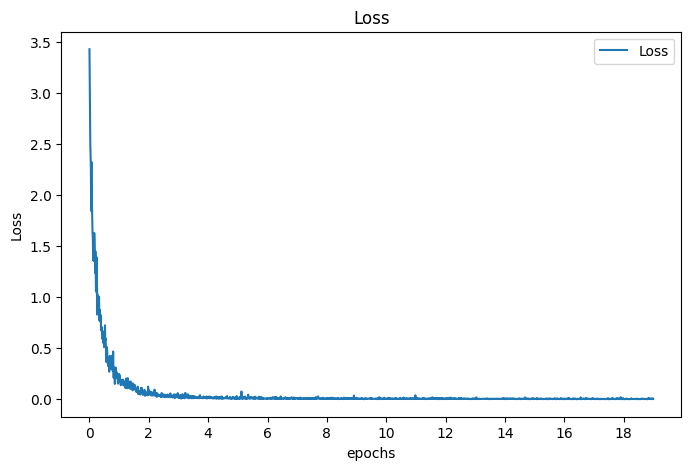

In [23]:
plotting(history)